<a href="https://colab.research.google.com/github/abhishekshakya/image_captioning_pytorch/blob/master/newImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade scipy==1.3.3

Requirement already up-to-date: scipy==1.3.3 in /usr/local/lib/python3.6/dist-packages (1.3.3)


In [ ]:
from google.colab import files
files.upload()
#upload kaggle API json file in order to use kaggle API for downloading Flicker8k dataset

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d shadabhussain/flickr8k

100% 2.12G/2.13G [01:22<00:00, 20.3MB/s]
100% 2.13G/2.13G [01:22<00:00, 27.8MB/s]


In [ ]:
!unzip flickr8k.zip

In [ ]:
!ls

flickr8k.zip  Flickr_Data  model_weights.h5  train_encoded_images.p
flickr_data   kaggle.json  sample_data


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import re
from tqdm.notebook import tqdm
import random

In [ ]:
#data retrive--------------------------------------------------------------------------------
img_idx = []
data = {}
with open('/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt',mode='r',encoding='utf8') as f:
    arr = f.readlines()

In [ ]:
for line in arr:
    img = line.split()[0][:-2]
    img_idx.append(img)
    caption = line.split()[1:]
    
    if data.get(img) is None:
        data[img] = [' '.join(caption)]
    else:
        data[img].append(' '.join(caption))

In [ ]:
BASE = '/content/flickr_data/Flickr_Data/Images/'

In [ ]:
img_idx = [x for x in data.keys()]

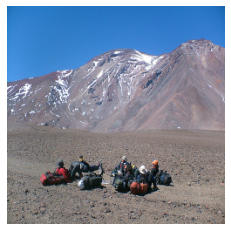

['a group of backpackers lay on the dry ground .', 'A group of hikers are resting on the ground in front of some mountains .', 'People camp with the mountains in the background .', 'Several hikers rest with their gear in front of a mountain .', 'The group of hikers is resting in front of a mountain .']


In [ ]:
plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(BASE+img_idx[78]),cv2.COLOR_BGR2RGB),(250,250)))
plt.axis('off')
plt.show()

print(data[img_idx[78]])

In [ ]:
#text cleaning----------------------------------------------------------------------------------
def cleaning(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ',sentence)
    sentence = sentence.split()
    sentence = [x for x in sentence if len(x)>1]
    sentence = ' '.join(sentence)
    return "_SOS_ "+sentence+" _EOS_"

In [ ]:
for img in img_idx:
    for i,sent in enumerate(data[img]):
        cleaned_sent = cleaning(sent)
        data[img][i] = cleaned_sent

In [ ]:
data[img_idx[0]]

['_SOS_ child in pink dress is climbing up set of stairs in an entry way _EOS_',
 '_SOS_ girl going into wooden building _EOS_',
 '_SOS_ little girl climbing into wooden playhouse _EOS_',
 '_SOS_ little girl climbing the stairs to her playhouse _EOS_',
 '_SOS_ little girl in pink dress going into wooden cabin _EOS_']

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torchvision.models import resnet50, inception_v3
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
def make_dic(data):
  word2idx = {'_SOS_':2, '_EOS_':1, '__':0}
  idx2word = {2:'_SOS_', 1:'_EOS_', 0:'__'}
  idx = 3
  for img in data.keys():
    for one_caption in data[img]:
      for word in one_caption.split():
        if word not in word2idx:
            word2idx[word] = idx
            idx2word[idx] = word
            idx += 1

  return word2idx, idx2word

word2idx, idx2word = make_dic(data)

In [ ]:
#this will give img in X and correspojnding vectorized captions in Y
class FlickerDataset(Dataset):
    
    def __init__(self,file, word2idx, idx2word):
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.max_len = 0
        self.X = []
        self.Y = []
        self.createVocab(file);
        self.padding()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        trans = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])

        ])
        return trans(self.X[idx]), self.Y[idx]
    
    def createVocab(self,file):
        with open(file,mode='r',encoding='utf8') as f:
            lst = f.readlines()
        
        for img in tqdm(lst):
            captions_lst = data[img[:-1]]
            # img_arr = cv2.cvtColor(cv2.imread(BASE+img[:-1]),cv2.COLOR_BGR2RGB)
            # img_arr = cv2.resize(img_arr,(250,250))
            img = Image.open(BASE+img[:-1])
            img = img.convert('RGB')
            img = img.resize((299,299))

            for one_caption in captions_lst:
                self.X.append(img)
                out = []
                for word in one_caption.split():
                    out.append(self.word2idx[word])
                self.Y.append(torch.tensor(out))
                self.max_len = max(self.max_len,len(out))

    def padding(self):
      self.Y = nn.utils.rnn.pad_sequence(self.Y,batch_first=True)
        # for i,caption in enumerate(self.Y):
        #     self.Y[i] = torch.FloatTensor(caption + [2]*(self.max_len-len(caption)))
                
                

In [ ]:
dataset = FlickerDataset('/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt', word2idx, idx2word)

In [ ]:
valid_data = FlickerDataset('/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt', word2idx, idx2word)
print(len(valid_data))
print(valid_data[0][1])


5000
tensor([   2,   23,  147,   91,  203,  387,   39,  419,    7,  250, 1096,  261,
          23,   94,   81,  186,  147,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0])


In [ ]:
print(len(dataset),dataset.max_len)
print(len(idx2word))
print(dataset[0][1])
print(idx2word[7320])

30000 35
8427
tensor([  2,  27,  28,   7, 119, 229,  41,  28,   4,  23, 178,   1,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0])
verbal


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


_SOS_ the man and dog which is leaping into the air are playing frisbee _EOS_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ 5000


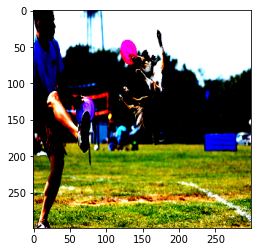

In [ ]:
plt.imshow(valid_data[264][0].permute(1,2,0))
for id in (valid_data[264][1]):
  print(idx2word[int(id)], end=' ')
print(len(valid_data))

In [ ]:

class encoder(nn.Module):
  def __init__(self, embded_dim):
    super().__init__()
    self.cnn = inception_v3(pretrained=True, aux_logits=False)
    
    for params in self.cnn.parameters():
      params.requires_grad_(False)
    
    self.cnn.fc = nn.Linear(in_features=self.cnn.fc.in_features,out_features=embded_dim)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)

  def forward(self,x):
    '''
    x -> image with 3 channels [batch ,3, height, width]
    '''
    out = self.cnn(x) #shape [batch, embed_size]
    out = self.relu(out)
    out = self.dropout(out)
    return out


class decoder(nn.Module):
  def __init__(self, vocab_size, hidden_size, embed_size, layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.layers = layers
    self.embed = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=layers, batch_first = True)
    self.fc = nn.Linear(hidden_size, vocab_size)
    self.dropout = nn.Dropout(0.5)
    

  def forward(self, enc_out, x):
    '''
    enc_out -> [batch,  embed] encoder output
    x -> [batch, seq-1] captions
    '''
    batch_size = x.shape[0]
    self.seq_len = x.shape[1]
    embed_size = enc_out.shape[1]

    embeds = self.embed(x) #[batch, seq, embed_size]
    embeds = self.dropout(embeds) 
    enc_out = enc_out.unsqueeze(1) #[batch, 1, embed_size]

    inp = torch.cat((enc_out, embeds), 1) #concatination on dim=1(seq)  shape [batch, seq_len, embed_size]

    outputs, _ = self.lstm(inp) #output [batch, seq_len, hidden_size]
    outputs = self.fc(outputs) # [batch, seq_len, vocab_size]

    return outputs


  def generate(self, x, enc_out, seq_len):
    '''
    generating captions one by one
    x = [batch, img]
    '''
    batch_size = x.shape[0]

    # hidden = torch.zeros(self.layers,batch_size,self.hidden_size).to(device)
    # cell = torch.zeros(self.layers,batch_size,self.hidden_size).to(device)
    states = None

    results = []

    with torch.no_grad():

      out = enc_out.unsqueeze(1) #[batch, 1, embed_size]

      for i in range(seq_len):
        # print(out.shape)
        out, states = self.lstm(out, states) #out [batch, 1, hidden_size], (hidden, cell) -> [batch, layers, hidden_size]
        # print(out.shape)
        out = out.squeeze(1) # out [batch, hidden_size]
        out = self.fc(out) # [batch, vocab_size]
        # print(out.shape)
        pred = out.argmax(1) #[batch]

        results.append(pred.item())

        out = self.embed(pred) #[batch, embed_size]
        out = out.unsqueeze(1) #[batch, 1, embed_size]

    return results


class EncoderDecoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, x, y):
    '''
    x -> [batch, img]
    y -> [batch, seq_len-1]
    '''
    enc_out = self.encoder(x) #[batch, embed_size]
    dec_out = self.decoder(enc_out, y.long()) #[batch, seq_len, vocab_size]

    return dec_out


In [ ]:
batch_size = 256
embed_size = 256
hidden_size = 256
layers = 1
learning_rate = 0.0008
vocab_size = len(word2idx)
epochs = 20


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
myloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)
valid_loader =  DataLoader(dataset=valid_data, batch_size = batch_size, shuffle=True)

In [ ]:
it1 = iter(myloader)
it2 = iter(valid_loader)
x1, y1 = next(it1)
x2, y2 = next(it2)
print(x1.shape, y1.shape, x2.shape, y2.shape)

torch.Size([256, 3, 299, 299]) torch.Size([256, 35]) torch.Size([256, 3, 299, 299]) torch.Size([256, 31])


In [ ]:
device

device(type='cuda')

In [ ]:

Encoder = encoder(embed_size).to(device)
Decoder = decoder(vocab_size, hidden_size, embed_size, layers).to(device)

model = EncoderDecoder(Encoder, Decoder).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)

#changed inception v3 model, dropout, relu, cross entropy loss in new reshape


In [ ]:
device

device(type='cuda')

In [ ]:
def captions(x,y=None, seq=35):
  '''
  predicition of caption for a given image
  '''
  caps = []
  plt.imshow(x.permute(1,2,0))
  plt.show()
  x = x.unsqueeze(0)
  x = x.to(device)
  with torch.no_grad():
    enc_out = model.encoder(x)
    res = model.decoder.generate(x,enc_out,seq)
    
    print('predicted caption')
    for id in res:
      print(idx2word[id],end=' ')
      caps.append(idx2word[id])
      if id == 1:
        break
    
  return caps


In [ ]:
train_loss = []
val_loss = []
for epoch in tqdm(range(epochs)):
  for id, (x,y) in enumerate(tqdm(myloader)):
    optimizer.zero_grad()
        
    x = x.to(device) #[batch, img]
    y = y.to(device) #[batch, seq_len]
    out = model(x,y[:,:-1])# [batch, seq_len, vocab_size]

    y = y.reshape(-1)
    out = out.reshape(-1,out.shape[2])
#     out = out.permute(0,2,1)
    loss = criterion(out,y)

    loss.backward()
    optimizer.step()

    
  for xv, yv in tqdm(valid_loader):
    with torch.no_grad():
        xv = xv.to(device)
        yv = yv.to(device)
        outv = model(xv,yv[:,:-1])
        yv = yv.reshape(-1)
        outv = outv.reshape(-1,outv.shape[2])
#         outv = outv.permute(0,2,1)
        valid_loss = criterion(outv, yv)  
  
  print(f"[{epoch}/{epochs}] epoch | loss=> [{loss.item()}] | valid_loss => {valid_loss.item()}")
  train_loss.append(loss.item())
  val_loss.append(valid_loss.item())


[0/20] epoch | loss=> [4.651838302612305] | valid_loss => 4.51392936706543



[1/20] epoch | loss=> [4.048438549041748] | valid_loss => 4.217507362365723



[2/20] epoch | loss=> [3.870182991027832] | valid_loss => 4.138171672821045



[3/20] epoch | loss=> [3.613814353942871] | valid_loss => 3.935770034790039



[4/20] epoch | loss=> [3.7816834449768066] | valid_loss => 3.8748674392700195



[5/20] epoch | loss=> [3.902482748031616] | valid_loss => 3.8670761585235596



[6/20] epoch | loss=> [3.4978885650634766] | valid_loss => 3.8270256519317627



[7/20] epoch | loss=> [3.518181800842285] | valid_loss => 3.6979546546936035



[8/20] epoch | loss=> [3.4500510692596436] | valid_loss => 3.551935911178589



[9/20] epoch | loss=> [3.611356019973755] | valid_loss => 3.606816053390503



[10/20] epoch | loss=> [3.334181070327759] | valid_loss => 3.4542927742004395



[11/20] epoch | loss=> [3.338312864303589] | valid_loss => 3.54490327835083



[12/20] epoch | loss=> [3.1228320598602295] | valid_loss => 3.409517288208008



[13/20] epoch | loss=> [3.116966485977173] | valid_loss => 3.359170913696289



[14/20] epoch | loss=> [3.248826265335083] | valid_loss => 3.448795795440674



[15/20] epoch | loss=> [3.0241377353668213] | valid_loss => 3.5498580932617188



[16/20] epoch | loss=> [2.841451644897461] | valid_loss => 3.3643035888671875



[17/20] epoch | loss=> [3.0373857021331787] | valid_loss => 3.383035182952881



[18/20] epoch | loss=> [3.029858350753784] | valid_loss => 3.416919708251953



[19/20] epoch | loss=> [2.988370895385742] | valid_loss => 3.36964750289917



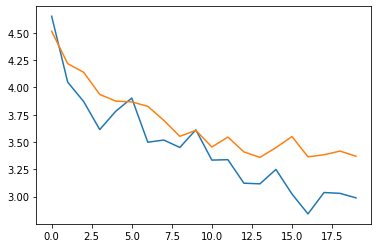

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

In [ ]:
torch.save(model.state_dict(),'model.pt')
from google.colab import files
files.download('model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


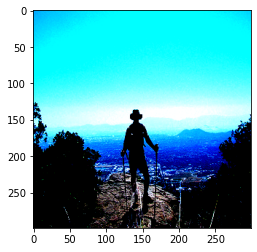

predicted caption
_SOS_ man in red shirt is standing on the edge of the edge of the ocean _EOS_ 

['_SOS_',
 'man',
 'in',
 'red',
 'shirt',
 'is',
 'standing',
 'on',
 'the',
 'edge',
 'of',
 'the',
 'edge',
 'of',
 'the',
 'ocean',
 '_EOS_']

In [ ]:
captions(dataset[2506][0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


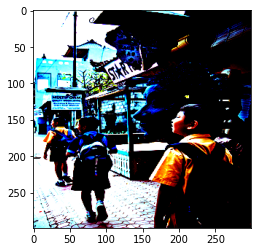

predicted caption
_SOS_ two children are playing in the water _EOS_ 

['_SOS_', 'two', 'children', 'are', 'playing', 'in', 'the', 'water', '_EOS_']

In [ ]:
captions(dataset[3506][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


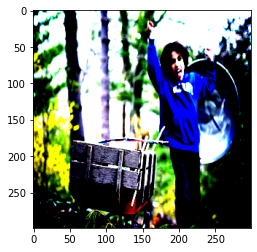

predicted caption
_SOS_ man in blue shirt is standing on the beach _EOS_ 

['_SOS_',
 'man',
 'in',
 'blue',
 'shirt',
 'is',
 'standing',
 'on',
 'the',
 'beach',
 '_EOS_']

In [ ]:
captions(dataset[4177][0])